In [27]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

In [28]:
merger = md.Merger(data_dir="data", load_from_raw=False, load_from_agg=True)

In [29]:
# merger.convert_deaths_df()
df = merger.merge_deaths_df()

In [30]:
list(df["date"].unique())

[numpy.datetime64('2020-03-31T00:00:00.000000000')]

In [31]:
df_additional = merger.df["details"][["date","additional.infected"]].set_index("date")

In [32]:
df_tests = merger.show_kpi_hu()[["tests"]].reset_index()
df_tests["index"] = pd.to_datetime(df_tests["index"], format='%Y-%m-%d').dt.date
df_tests["additional.tests"] = df_tests.apply(
    lambda row: row["tests"]-df_tests[
        df_tests["index"]==row["index"] - pd.Timedelta(1, unit='D')
    ]["tests"].max(), 
    axis=1
)
df_tests = df_tests.set_index("index")

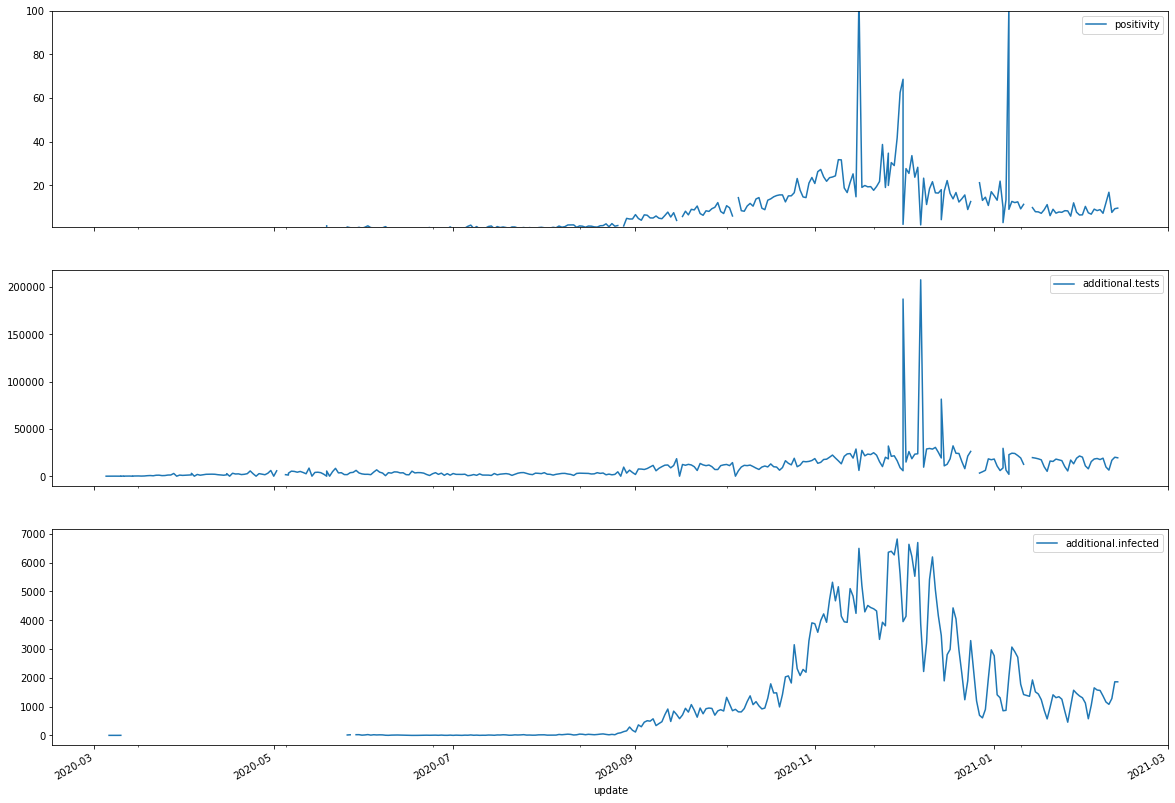

In [33]:
df_join = df_tests.join(df_additional).reset_index()
df_join["positivity"] = df_join["additional.infected"]/df_join["additional.tests"]*100
df_join["Country/Region"] = "HU"
df_join["update"] = df_join["index"]
(fig, ax) = plt.subplots(figsize=(20,15), nrows=3, sharex=True)
ax[0].set_ylim(1,100)
df_join.plot(x="update", y="positivity", ax=ax[0])
df_join.plot(x="update", y="additional.tests", ax=ax[1])
df_join.plot(x="update", y="additional.infected", ax=ax[2])
plt.show()

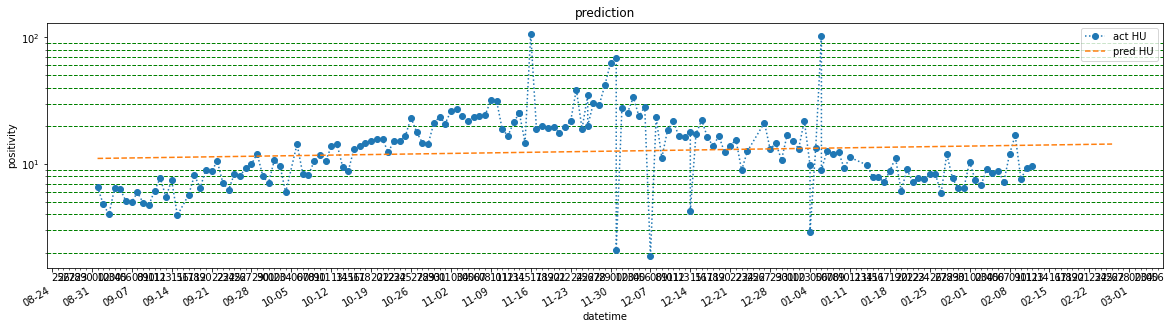

Coefficient of determination: {'HU': 0.011645801828231162}
Evolution factor per day: {'HU': 1.0}
Doubling in day(s): {'HU': 2.0}


,index,tests,additional.tests,additional.infected,positivity,Country/Region,update
381,2021-02-08,3275582.0,9720.0,1160.0,11.934156,HU,2021-02-08
382,2021-02-09,3281992.0,6410.0,1079.0,16.833073,HU,2021-02-09
383,2021-02-10,3298814.0,16822.0,1279.0,7.603139,HU,2021-02-10
384,2021-02-11,3318850.0,20036.0,1862.0,9.293272,HU,2021-02-11
385,2021-02-12,3338289.0,19439.0,1860.0,9.568393,HU,2021-02-12


In [34]:
tmpDf = md.DataProcessing.Analyse.start_analyse(
    df_join[
        (df_join["additional.tests"]>0) & (df_join["index"]>=pd.Timestamp("2020-09-01"))
    ].dropna(),
    ["HU"],
    "positivity", 
    "positivity"
)
df_join.tail()

# Check plausibility

In [35]:
# Details
selected_details_df = merger.df["details"][[
    "date", "additional.infected", "additional.deaths", 
    "cumulated.infected", "cumulated.recoveredFromHospital", 
    "onVentilator", "hospital", "active.infected"
]].copy()
selected_details_df.columns = [
    "date", "news.add.infected", "news.add.deaths", 
    "news.cum.infected", "news.cum.recovered", 
    "news.onVentilator", "news.hospital", "news.active"
]
selected_details_df["date"] = pd.to_datetime(selected_details_df["date"], format='%Y-%m-%d').dt.date
selected_details_df["news.add.recovered"] = selected_details_df.apply(
    lambda row: row["news.cum.recovered"] - selected_details_df[
        selected_details_df["date"]<row["date"]
    ]["news.cum.recovered"].max(), axis=1
)
selected_details_df = selected_details_df.set_index("date")

# KPI
selected_kpi_df = merger.show_kpi_hu()[["infected"]].copy().reset_index()
selected_kpi_df.columns = ["date", "kpi.cum.infected"]
selected_kpi_df["date"] = pd.to_datetime(selected_kpi_df["date"], format='%Y-%m-%d').dt.date
selected_kpi_df = selected_kpi_df.set_index("date")

selected_details_df.join(selected_kpi_df).tail()

,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,kpi.cum.infected
date,,,,,,,,,
2021-02-08,1160.0,65.0,377655,281839.0,295.0,3717.0,82661.0,2076.0,377655.0
2021-02-09,1079.0,94.0,378734,283282.0,304.0,3792.0,82203.0,1443.0,378734.0
2021-02-10,1279.0,98.0,380013,285022.0,296.0,3747.0,81644.0,1740.0,380013.0
2021-02-11,1862.0,97.0,381875,287134.0,299.0,3799.0,81297.0,2112.0,381875.0
2021-02-12,1860.0,99.0,383735,289520.0,299.0,3828.0,80672.0,2386.0,383735.0


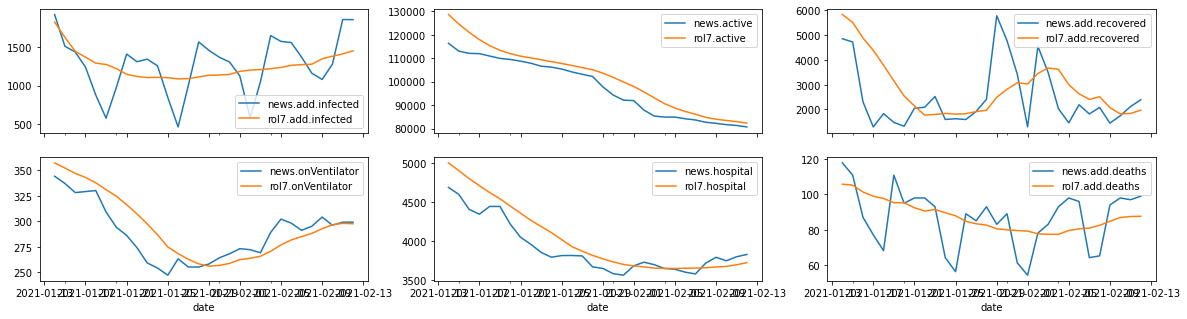

In [36]:
(fig, ax) = plt.subplots(figsize=(20,5), nrows=2, ncols=3, sharex=True)
plot_df = selected_details_df
configuration = {
    "add.infected":(0, 0), "onVentilator":(1,0),   # 1st col
    "active":(0,1),        "hospital":(1,1),       # 2nd col
    "add.recovered":(0,2), "add.deaths":(1,2)      # 3rd col
}
for category in configuration:
    plot_df["rol7.{}".format(category)] = plot_df.rolling(7).mean()[["news.{}".format(category)]]
plot_df = plot_df.reset_index().tail(30)

for (category, position) in configuration.items():
    my_ax = ax[position[0]][position[1]]
    plot_df.plot(x="date", y="news.{}".format(category), ax=my_ax)
    plot_df.plot(x="date", y="rol7.{}".format(category), ax=my_ax)
plt.show()

In [37]:
#plot_df["add.infected"] = plot_df.apply(lambda row: plot_df[plot_df["date"]<], axis=1)
#plot_df.head()
plot_df.tail(10)

,date,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,rol7.add.infected,rol7.onVentilator,rol7.active,rol7.hospital,rol7.add.recovered,rol7.add.deaths
334,2021-02-03,1048.0,83.0,370336,272284.0,269.0,3697.0,85313.0,3481.0,1207.857143,265.571429,93039.571429,3652.857143,3669.714286,77.285714
335,2021-02-04,1652.0,93.0,371988,274308.0,289.0,3648.0,84848.0,2024.0,1219.714286,270.428571,90567.000000,3649.857143,3615.000000,77.285714
336,2021-02-05,1576.0,98.0,373564,275764.0,302.0,3638.0,84870.0,1456.0,1236.428571,276.714286,88726.714286,3648.285714,2997.285714,79.428571
337,2021-02-06,1561.0,96.0,375125,277949.0,298.0,3601.0,84150.0,2185.0,1263.714286,281.571429,87282.285714,3651.000000,2627.714286,80.428571
338,2021-02-07,1370.0,64.0,376495,279763.0,291.0,3578.0,83642.0,1814.0,1272.714286,284.857143,86074.857143,3653.285714,2399.285714,80.857143
339,2021-02-08,1160.0,65.0,377655,281839.0,295.0,3717.0,82661.0,2076.0,1277.857143,288.000000,84759.000000,3658.285714,2511.285714,82.428571
340,2021-02-09,1079.0,94.0,378734,283282.0,304.0,3792.0,82203.0,1443.0,1349.428571,292.571429,83955.285714,3667.285714,2068.428571,84.714286
341,2021-02-10,1279.0,98.0,380013,285022.0,296.0,3747.0,81644.0,1740.0,1382.428571,296.428571,83431.142857,3674.428571,1819.714286,86.857143
342,2021-02-11,1862.0,97.0,381875,287134.0,299.0,3799.0,81297.0,2112.0,1412.428571,297.857143,82923.857143,3696.000000,1832.285714,87.428571
343,2021-02-12,1860.0,99.0,383735,289520.0,299.0,3828.0,80672.0,2386.0,1453.000000,297.428571,82324.142857,3723.142857,1965.142857,87.571429


In [39]:
baseDf = pd.read_csv("data/map_data/map_dataframe_per_megye.csv", delimiter=",")[['date','region','confirmed']]
# Convert date column and add week/dayofweek
baseDf['date'] =  pd.to_datetime(baseDf['date'], format='%Y-%m-%d')
last_kpi = baseDf[baseDf["date"].isin(["2021-01-22","2021-01-29","2021-02-05","2021-02-12"])].pivot(
    index="region",
    columns="date",
    values="confirmed"
)
last_kpi.columns = ["d-21", "d-14", "d-7", "d"]
last_kpi["w_2"] = last_kpi["d-14"] - last_kpi["d-21"]
last_kpi["w_1"] = last_kpi["d-7"] - last_kpi["d-14"]
last_kpi["w_0"] = last_kpi["d"] - last_kpi["d-7"]
last_kpi

,d-21,d-14,d-7,d,w_2,w_1,w_0
region,,,,,,,
Baranya,12404,12827,13242,13600,423,415,358
Borsod-Abaúj-Zemplén,19916,20373,20842,21557,457,469,715
Budapest,66525,67766,69256,71219,1241,1490,1963
Bács-Kiskun,16404,16837,17371,17894,433,534,523
Békés,12041,12228,12427,12628,187,199,201
Csongrád,16343,16687,16992,17371,344,305,379
Fejér,13643,14063,14409,14724,420,346,315
Győr-Moson-Sopron,20133,20416,20765,21323,283,349,558
Hajdú-Bihar,20205,20662,21131,21598,457,469,467
